In [1]:
import json
import pathlib
import pycolmap
import datetime
import random

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler, DataLoader, random_split

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pyvista as pv

import neural_orientation_field.utils as utils
import neural_orientation_field.colmap.colmap_utils as colutils
from neural_orientation_field.nerf.dataset import NeRFImageDataset, NeRFPriorImageDataset, NeRFRayDataset
from neural_orientation_field.nerf.model import NeRfCoarseModel, NeRfFineModel
from neural_orientation_field.nerf.utils import pos_encode, static_volumetric_renderer, adaptive_volumetric_renderer, cam_ray_from_pose, nerf_image_render

In [2]:
# Seed rng for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Load Dataset

In [3]:
# Output
CHECKPOINT_PATH = "../../data/output/nerf/model/"
EVAL_OUTPUT_PATH = "../../data/output/nerf/eval/"

checkpoint_path = pathlib.Path(CHECKPOINT_PATH).resolve()
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True, exist_ok=True)
eval_path = pathlib.Path(EVAL_OUTPUT_PATH).resolve()
if not eval_path.exists():
    eval_path.mkdir(parents=True, exist_ok=True)

checkpoint_path, eval_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/output/nerf/model'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/output/nerf/eval'))

## COLMAP Image Dataset

In [4]:
# # Input
# IMAGE_PATH = "../../data/images/hoover-tower-mid-res/"
# COLMAP_MODEL_PATH = "../../data/output/colmap/hoover-tower-mid-res/model/0/"
# 
# image_dir = pathlib.Path(IMAGE_PATH).resolve()
# colmap_model_path = pathlib.Path(COLMAP_MODEL_PATH).resolve()
# 
# image_dir, colmap_model_path

In [5]:
# image_dataset = NeRFImageDataset(image_dir, colmap_model_path)
# num_train = int(0.9 * len(image_dataset))
# num_test = len(image_dataset) - num_train
# image_dataset_train, image_dataset_test = random_split(image_dataset, [num_train, num_test])
# len(image_dataset_train), len(image_dataset_test)

## Blender Image Dataset

In [6]:
# Input
IMAGE_PATH = "../../data/images/blender-hair-long/"
CAMERA_PATH = "../../data/camera/blender-hair-long/"

image_path = pathlib.Path(IMAGE_PATH).resolve()
camera_path = pathlib.Path(CAMERA_PATH).resolve()

frame_name_path = camera_path / "frame-names.txt"
cam_transform_path = camera_path / "camera-transforms.npy"
cam_param_path = camera_path / "camera-params.npy"

image_path, frame_name_path, cam_transform_path, cam_param_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/blender-hair-long'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/camera/blender-hair-long/frame-names.txt'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/camera/blender-hair-long/camera-transforms.npy'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/camera/blender-hair-long/camera-params.npy'))

In [7]:
# Blender Image Dataset
with open(frame_name_path, "r") as frame_path_file:
    frame_names = frame_path_file.read().split("\n")
    frame_paths = [image_path / frame_name for frame_name in frame_names]
with open(cam_transform_path, "rb") as cam_transform_file:
    cam_transforms = np.load(cam_transform_file)
with open(cam_param_path, "rb") as cam_param_file:
    cam_params = np.load(cam_param_file)
image_dataset = NeRFPriorImageDataset(frame_paths, cam_params, cam_transforms)
num_train = int(0.9 * len(image_dataset))
num_test = len(image_dataset) - num_train
image_dataset_train, image_dataset_test = random_split(image_dataset, [num_train, num_test])
len(image_dataset_train), len(image_dataset_test)

(115, 13)

In [8]:
with tqdm(total=len(image_dataset_train), desc="Processing Image") as progress:
    ray_dataset = NeRFRayDataset(image_dataset_train, progress)

Processing Image:   0%|          | 0/115 [00:00<?, ?it/s]

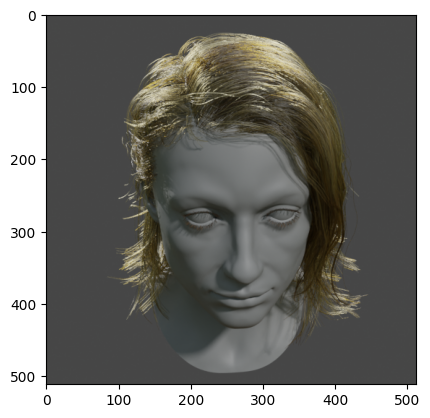

In [9]:
idx = 2
image, cam_transform, (h, w), (f, cx, cy) = image_dataset[idx]
plt.imshow(image)
cam_orig, cam_ray_world = cam_ray_from_pose(cam_transform, h, w, f, cx, cy)

In [10]:
# Visualize camera rays.
# origins = np.tile(cam_orig[np.newaxis, np.newaxis, :], (image.shape[0], image.shape[1], 1)).reshape(-1, 3)
# directions = cam_ray_world.reshape(-1, 3)
# colors = image.reshape(-1, 3)
# sample_idxs = np.arange(0, colors.shape[0])
# np.random.shuffle(sample_idxs)
# sample_idxs = sample_idxs[:1024]
# origins = origins[sample_idxs]
# directions = directions[sample_idxs]
# colors = colors[sample_idxs]

# origins = []
# directions = []
# colors = []
# for i in range(65535):
#     idx = random.randint(0, len(ray_dataset))
#     origin, direction, color = ray_dataset[idx]
#     origins.append(origin)
#     directions.append(direction)
#     colors.append(color)
# origins = np.array(origins)
# directions = np.array(directions)
# colors = np.array(colors)
# 
# # Normalize directions if necessary
# directions = directions / np.linalg.norm(directions, axis=1)[:, np.newaxis]
# 
# # Create the PyVista PolyData object
# vectors = pv.PolyData(origins)
# 
# # Add the directions and colors as point data
# vectors["directions"] = directions
# vectors["colors"] = colors
# 
# # Create the glyphs (arrows)
# arrows = vectors.glyph(orient="directions", scale=False, factor=1)
# 
# # Plot the arrows with colors
# plotter = pv.Plotter()
# plotter.add_mesh(arrows, scalars="colors", rgb=True)
# plotter.show()

# NeRF

In [11]:
# Use MPS device.
USE_DEVICE = "mps"

if USE_DEVICE == "mps" and torch.mps.is_available():
    device = torch.device("mps")
elif USE_DEVICE == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# NeRF Training

In [12]:
# Near/far clipping distance.
nc = 1
fc = 8
# Positional encoding number.
coarse_pos_encode = 4
fine_pos_encode = 6
samples_per_ray = 4
max_subd_samples = 4
# Hyper parameters.
lr = 1e-4
num_iters = 4
ray_batch_size = 8192
# Training settings.
size_train_ray = 1
save_image_every_n_batch = 128

# Init model.
coarse_model = NeRfCoarseModel(num_encoding_functions=coarse_pos_encode)
coarse_model.to(device)
coarse_optimizer = torch.optim.Adam(coarse_model.parameters(), lr=lr)

fine_model = NeRfFineModel(num_encoding_functions=fine_pos_encode)
fine_model.to(device)
fine_optimizer = torch.optim.Adam(fine_model.parameters(), lr=lr)

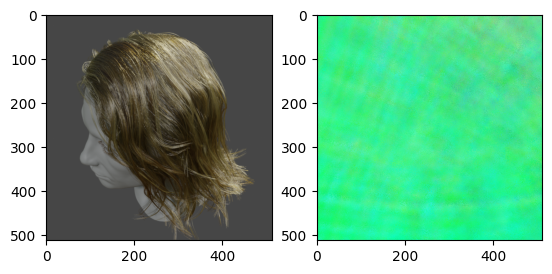

In [13]:
# Test rendering.
image_eval, cam_transform, (h, w), (f, cx, cy) = image_dataset_test[0]
cam_orig, cam_ray_world = cam_ray_from_pose(cam_transform, h, w, f, cx, cy)
coarse_model.eval()
_, image_pred = nerf_image_render(
    coarse_model,
    fine_model,
    cam_orig,
    cam_ray_world,
    ray_batch_size,
    nc,
    fc,
    samples_per_ray,
    max_subd_samples,
    coarse_pos_encode,
    fine_pos_encode,
    device
)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval)
ax_pred.imshow(image_pred.detach().cpu())

In [ ]:
coarse_model.train()
fine_model.train()

train_sampler = RandomSampler(data_source=ray_dataset, num_samples=int(size_train_ray * len(ray_dataset)))
dataloader = DataLoader(
    ray_dataset,
    sampler=train_sampler,
    batch_size=ray_batch_size,
)

writer = SummaryWriter(flush_secs=1)
test_image_idx = 0
test_image, _, _, _ = image_dataset_test[test_image_idx]
writer.add_image("Test Image Ground Truth", test_image, dataformats="HWC")
for it in tqdm(range(num_iters)):
    # One iteration of the training.
    for batch_i, (cam_orig_batch, cam_ray_batch, color_batch) in enumerate(tqdm(dataloader)):
        cam_orig_batch = cam_orig_batch.type(torch.float32).to(device)
        cam_ray_batch = cam_ray_batch.type(torch.float32).to(device)
        color_batch = color_batch.type(torch.float32).to(device)
        coarse_color_pred, occupancy, sample_depth = static_volumetric_renderer(
            coarse_model,
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            nc,
            fc,
            num_sample=samples_per_ray,
            num_pos_encode=coarse_pos_encode,
            device=device
        )
        loss_coarse = torch.nn.functional.mse_loss(coarse_color_pred, color_batch)
        fine_color_pred, _, _ = adaptive_volumetric_renderer(
            fine_model,
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            occupancy,
            sample_depth,
            max_subd_sample=max_subd_samples,
            num_pos_encode=fine_pos_encode,
            device=device
        )
        loss_fine = torch.nn.functional.mse_loss(fine_color_pred, color_batch)
        loss = loss_coarse + loss_fine
        loss.backward()
        coarse_optimizer.step()
        coarse_optimizer.zero_grad()
        fine_optimizer.step()
        fine_optimizer.zero_grad()
        writer.add_scalar("Coarse Loss", loss_coarse, (it * len(dataloader) + batch_i) * ray_batch_size)
        writer.add_scalar("Fine Loss", loss_fine, (it * len(dataloader) + batch_i) * ray_batch_size)
        if batch_i % save_image_every_n_batch == 0:
            coarse_model.eval()
            fine_model.eval()
            _, cam_transform, (h, w), (f, cx, cy) = image_dataset_test[0]
            cam_orig, cam_ray_world = cam_ray_from_pose(cam_transform, h, w, f, cx, cy)
            coarse_pred, fine_pred = nerf_image_render(
                coarse_model,
                fine_model,
                cam_orig,
                cam_ray_world,
                ray_batch_size,
                nc,
                fc,
                samples_per_ray,
                max_subd_samples,
                coarse_pos_encode,
                fine_pos_encode,
                device
            )
            writer.add_image("Rendered Test Image Fine", fine_pred, (it *
                             len(dataloader) + batch_i) * ray_batch_size, dataformats="HWC")
            writer.add_image("Rendered Test Image Coarse", coarse_pred, (it *
                             len(dataloader) + batch_i) * ray_batch_size, dataformats="HWC")
            coarse_model.train()
            fine_model.train()
    torch.save(coarse_model.state_dict(), checkpoint_path / f"coarse_epoch_{it}.pth")
    torch.save(fine_model.state_dict(), checkpoint_path / f"fine_epoch_{it}.pth")
writer.close()

torch.save(coarse_model.state_dict(), checkpoint_path / f"coarse_final.pth")
torch.save(fine_model.state_dict(), checkpoint_path / f"fine_final.pth")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3680 [00:00<?, ?it/s]

# Evaluation

In [ ]:
# Load model.
coarse_model_path = checkpoint_path / f"coarse_final.pth"
coarse_model = NeRfCoarseModel(num_encoding_functions=coarse_pos_encode)
coarse_model.load_state_dict(torch.load(coarse_model_path))
coarse_model.to(device)
fine_model_path = checkpoint_path / f"fine_final.pth"
fine_model = NeRfFineModel(num_encoding_functions=fine_pos_encode)
fine_model.load_state_dict(torch.load(fine_model_path))
fine_model.to(device)

In [ ]:
# Eval rendering.
coarse_model.eval()
fine_model.eval()
for idx, (image_eval, cam_transform, (h, w), (f, cx, cy)) in enumerate(tqdm(image_dataset_test)):
    cam_orig, cam_ray_world = cam_ray_from_pose(cam_transform, h, w, f, cx, cy)
    _, image_pred = nerf_image_render(
        coarse_model,
        fine_model,
        cam_orig,
        cam_ray_world,
        ray_batch_size,
        nc,
        fc,
        samples_per_ray,
        max_subd_samples,
        coarse_pos_encode,
        fine_pos_encode,
        device
    )
    image_eval = (image_eval * 255).astype(np.uint8)
    image_pred = (image_pred.detach().cpu().numpy() * 255).astype(np.uint8)
    image = Image.fromarray(image_eval)
    image.save(eval_path / f"test_{idx}_ground_truth.jpg")
    image = Image.fromarray(image_pred)
    image.save(eval_path / f"test_{idx}_pred.jpg")